In [78]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pathlib

In [79]:
class ShapeChecker:
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        if isinstance(names, str):
            names = (names,)

        shape = tf.shape(tensor)
        rank = tf.rank(tensor)

        if rank != len(names):
            raise ValueError(
                f'Rank mismatch:\n'
                f'    found {rank}: {shape.numpy()}\n'
                f'    expected {len(names)}: {names}\n'
            )

        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            new_dim = shape[i]

            if broadcast and new_dim == 1:
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(
                    f"Shape mismatch for dimension: '{name}'\n"
                    f"    found: {new_dim}\n"
                    f"    expected: {old_dim}\n"
                )

In [80]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True
)

path_to_file = pathlib.Path(path_to_zip).parent / 'spa-eng/spa.txt'


def load_data(path):
    text = path.read_text(encoding='utf-8')

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    inp = [inp for targ, inp in pairs]
    targ = [targ for targ, inp in pairs]

    return targ, inp


targ, inp = load_data(path_to_file)
print(inp[-1])
print(targ[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.
If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [81]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

In [82]:
dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break

example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

tf.Tensor(
[b'\xc2\xbfA qui\xc3\xa9n est\xc3\xa1s mirando?'
 b'Tom no recuerda como hizo para tener el ojo morado.'
 b'\xc2\xbfA qu\xc3\xa9 hora vais a trabajar?'
 b'\xc3\x89l est\xc3\xa1 loco por ti.' b'Hablaba bien japon\xc3\xa9s.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Who are you staring at?'
 b'Tom has no recollection of how he got his black eye.'
 b'What time do you go to work?' b'He is mad about you.'
 b'She spoke Japanese well.'], shape=(5,), dtype=string)
b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [83]:
def tf_lower_and_split_punct(text):
    # Split accented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text


print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [84]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
)

input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
print(input_text_processor.get_vocabulary()[:10])

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']


In [89]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
)

output_text_processor.adapt(targ)
print(output_text_processor.get_vocabulary()[:10])

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']


In [86]:
example_tokens = input_text_processor(example_input_batch)
print(example_tokens[:3, :10])

tf.Tensor(
[[   2   13    8   80   76  888   12    3    0    0]
 [   2   10    9 1057   38  128   31  244    7 1207]
 [   2   13    8    5  138 3211    8  306   12    3]], shape=(3, 10), dtype=int64)


In [87]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
print(' '.join(tokens))

[START] ¿ a quien estas mirando ? [END]                  


Text(0.5, 1.0, 'Mask')

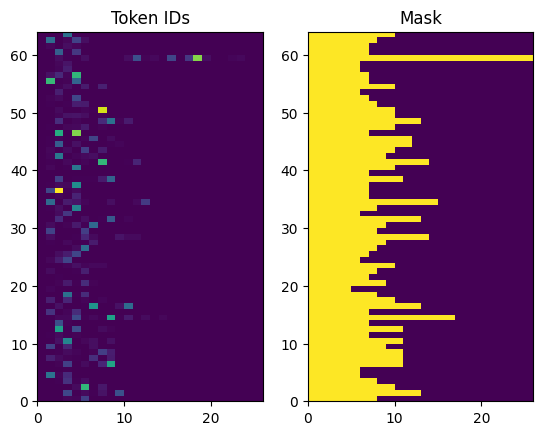

In [88]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [19]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(
            self.input_vocab_size,
            embedding_dim
        )

        # The GRU RNN layer processes those vectors sequentially.
        self.gru = tf.keras.layers.GRU(
            self.enc_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
        )

    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ('batch', 's'))

        # 2. The embedding layer looks up the embedding for each token.
        vectors = self.embedding(tokens)
        shape_checker(vectors, ('batch', 's', 'embed_dim'))

        # 3. The GRU processes the embedding sequence.
        #    output shape: (batch, s, enc_units)
        #    state shape: (batch, enc_units)
        output, state = self.gru(vectors, initial_state=state)
        shape_checker(output, ('batch', 's', 'enc_units'))
        shape_checker(state, ('batch', 'enc_units'))

        # 4. Returns the new sequence and its state.
        return output, state

In [20]:
embedding_dim = 256
units = 1024

In [21]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 15)
Encoder output, shape (batch, s, units): (64, 15, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [22]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        # For Eqn. (4), the  Bahdanau attention
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ('batch', 't', 'query_units'))
        shape_checker(value, ('batch', 's', 'value_units'))
        shape_checker(mask, ('batch', 's'))

        # From Eqn. (4), `W1@ht`.
        w1_query = self.W1(query)
        shape_checker(w1_query, ('batch', 't', 'attn_units'))

        # From Eqn. (4), `W2@hs`.
        w2_key = self.W2(value)
        shape_checker(w2_key, ('batch', 's', 'attn_units'))

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(
            inputs=[w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores=True,
        )
        shape_checker(context_vector, ('batch', 't', 'value_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))

        return context_vector, attention_weights

In [23]:
attention_layer = BahdanauAttention(units)
print((example_tokens != 0).shape)

(64, 15)


In [24]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0)
)

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 15)


In [26]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [27]:
print(attention_weights.shape)

(64, 2, 15)


In [28]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

In [29]:
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85 * top
a2.set_ylim([0.90 * top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

In [30]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        # For Step 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(
            self.output_vocab_size,
            embedding_dim
        )

        # For Step 2. The RNN keeps track of what's been generated so far.
        self.gru = tf.keras.layers.GRU(
            self.dec_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
        )

        # For step 3. The RNN output will be the query for the attention layer.
        self.attention = BahdanauAttention(self.dec_units)

        # For step 4. Eqn. (3): converting `ct` to `at`
        self.Wc = tf.keras.layers.Dense(
            dec_units,
            activation=tf.math.tanh,
            use_bias=False
        )

        # For step 5. This fully connected layer produces the logits for each
        # output token.
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [31]:
class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any


class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

In [32]:
def call(
        self,
        inputs: DecoderInput,
        state=None
) -> Tuple[DecoderOutput, tf.Tensor]:
    shape_checker = ShapeChecker()
    shape_checker(inputs.new_tokens, ('batch', 't'))
    shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
    shape_checker(inputs.mask, ('batch', 's'))

    if state is not None:
        shape_checker(state, ('batch', 'dec_units'))

    # Step 1. Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)
    shape_checker(vectors, ('batch', 't', 'embedding_dim'))

    # Step 2. Process one step with the RNN
    rnn_output, state = self.gru(vectors, initial_state=state)

    shape_checker(rnn_output, ('batch', 't', 'dec_units'))
    shape_checker(state, ('batch', 'dec_units'))

    # Step 3. Use the RNN output as the query for the attention over the
    # encoder output.
    context_vector, attention_weights = self.attention(
        query=rnn_output,
        value=inputs.enc_output,
        mask=inputs.mask
    )
    shape_checker(context_vector, ('batch', 't', 'dec_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    # Step 4. Eqn. (3): Join the context_vector and rnn_output
    #     [ct; ht] shape: (batch t, value_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

    # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)
    shape_checker(attention_vector, ('batch', 't', 'dec_units'))

    # Step 5. Generate logit predictions:
    logits = self.fc(attention_vector)
    shape_checker(logits, ('batch', 't', 'output_vocab_size'))

    return DecoderOutput(logits, attention_weights), state

In [33]:
Decoder.call = call

In [34]:
decoder = Decoder(
    output_text_processor.vocabulary_size(),
    embedding_dim,
    units
)

# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

# Run the decoder
dec_result, dec_state = decoder(
    inputs=DecoderInput(
        new_tokens=first_token,
        enc_output=example_enc_output,
        mask=(example_tokens != 0)
    ),
    state=example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


In [35]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
print(first_word[:5])

[['allows']
 ['brazilian']
 ['contains']
 ['due']
 ['part']]


In [36]:
dec_result, dec_state = decoder(
    DecoderInput(
        sampled_token,
        example_enc_output,
        mask=(example_tokens != 0)
    ),
    state=dec_state
)

In [38]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
print(first_word[:5])

[['latin']
 ['unfinished']
 ['irresponsible']
 ['understands']
 ['weekends']]


In [39]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

    def __call__(self, y_true, y_pred):
        shape_checker = ShapeChecker()
        shape_checker(y_true, ('batch', 't'))
        shape_checker(y_pred, ('batch', 't', 'logits'))

        # Calculate the loss for each item in the batch.
        loss = self.loss(y_true, y_pred)
        shape_checker(loss, ('batch', 't'))

        # Mask off the losses on padding.
        mask = tf.cast(y_true != 0, tf.float32)
        shape_checker(mask, ('batch', 't'))
        loss *= mask

        # Return the total.
        return tf.reduce_sum(loss)

In [40]:
class TrainTranslator(tf.keras.Model):
    def __init__(
            self,
            embedding_dim,
            units,
            input_text_processor,
            output_text_processor,
            use_tf_function=True
    ):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(
            input_text_processor.vocabulary_size(),
            embedding_dim,
            units
        )
        decoder = Decoder(
            output_text_processor.vocabulary_size(),
            embedding_dim,
            units
        )

        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        self.shape_checker = ShapeChecker()

    def train_step(self, inputs):
        self.shape_checker = ShapeChecker()
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)

In [41]:
def _preprocess(self, input_text, target_text):
    self.shape_checker(input_text, ('batch',))
    self.shape_checker(target_text, ('batch',))

    # Convert the text to token IDs
    input_tokens = self.input_text_processor(input_text)
    target_tokens = self.output_text_processor(target_text)
    self.shape_checker(input_tokens, ('batch', 's'))
    self.shape_checker(target_tokens, ('batch', 't'))

    # Convert IDs to masks.
    input_mask = input_tokens != 0
    self.shape_checker(input_mask, ('batch', 's'))

    target_mask = target_tokens != 0
    self.shape_checker(target_mask, ('batch', 't'))

    return input_tokens, input_mask, target_tokens, target_mask

In [42]:
TrainTranslator._preprocess = _preprocess

In [43]:
def _train_step(self, inputs):
    input_text, target_text = inputs

    (
        input_tokens,
        input_mask,
        target_tokens,
        target_mask
    ) = self._preprocess(input_text, target_text)

    max_target_length = tf.shape(target_tokens)[1]

    with tf.GradientTape() as tape:
        # Encode the input
        enc_output, enc_state = self.encoder(input_tokens)
        self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
        self.shape_checker(enc_state, ('batch', 'enc_units'))

        # Initialize the decoder's state to the encoder's final state.
        # This only works if the encoder and decoder have the same number of
        # units.
        dec_state = enc_state
        loss = tf.constant(0.0)

        for t in tf.range(max_target_length - 1):
            # Pass in two tokens from the target sequence:
            # 1. The current input to the decoder.
            # 2. The target for the decoder's next prediction.
            new_tokens = target_tokens[:, t:t + 2]
            step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                                   enc_output, dec_state)
            loss = loss + step_loss

        # Average the loss over all non padding tokens.
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

    # Apply an optimization step
    variables = self.trainable_variables
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}


In [44]:
TrainTranslator._train_step = _train_step

In [45]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

    # Run the decoder one step.
    decoder_input = DecoderInput(
        new_tokens=input_token,
        enc_output=enc_output,
        mask=input_mask
    )

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
    self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    self.shape_checker(dec_state, ('batch', 'dec_units'))

    # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)

    return step_loss, dec_state

In [46]:
TrainTranslator._loop_step = _loop_step

In [47]:
translator = TrainTranslator(
    embedding_dim,
    units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False
)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [48]:
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [49]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5607705>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5301647>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.473663>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.3184247>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.8204474>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.231979>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.6890397>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.7417436>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1920824>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1864996>}

CPU times: user 1min 30s, sys: 1min 22s, total: 2min 53s
Wall time: 28.2 s


In [50]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
    return self._train_step(inputs)

In [51]:
TrainTranslator._tf_train_step = _tf_train_step

In [52]:
translator.use_tf_function = True

In [53]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.109943>}

In [54]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0921903>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.11967>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.068065>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9768186>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.92688>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8019826>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7428646>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.729547>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7080584>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6664324>}

CPU times: user 1min 38s, sys: 36.1 s, total: 2min 14s
Wall time: 13 s


....................................................................................................


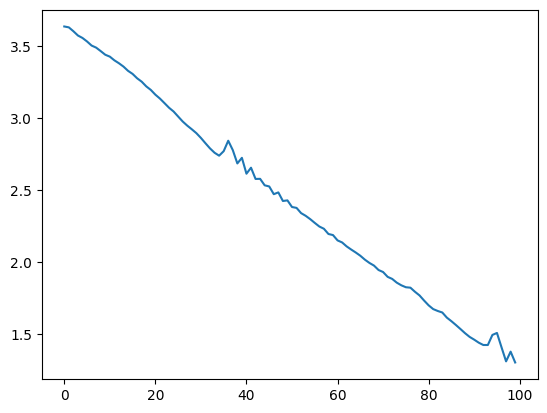

In [55]:
losses = []
for n in range(100):
    print('.', end='')
    logs = translator.train_step([example_input_batch, example_target_batch])
    losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [56]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor
)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [57]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])


batch_loss = BatchLogs('batch_loss')

In [58]:
train_translator.fit(
    dataset,
    epochs=3,
    callbacks=[batch_loss]
)

Epoch 1/3
1859/1859 [==============================] - 3182s 2s/step - batch_loss: 2.7496
Epoch 2/3
1859/1859 [==============================] - 2719s 1s/step - batch_loss: 1.1414
Epoch 3/3
1859/1859 [==============================] - 2856s 2s/step - batch_loss: 0.8362


Text(0, 0.5, 'CE/token')

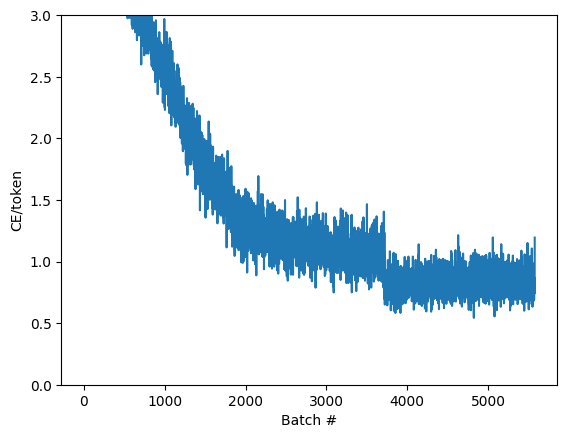

In [59]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [60]:
class Translator(tf.Module):

    def __init__(self, encoder, decoder, input_text_processor, output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor

        self.output_token_string_from_index = (
            tf.keras.layers.StringLookup(
                vocabulary=output_text_processor.get_vocabulary(),
                mask_token='',
                invert=True
            )
        )

        # The output should never generate padding, unknown, or start.
        index_from_string = tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token=''
        )
        token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask

        self.start_token = index_from_string(tf.constant('[START]'))
        self.end_token = index_from_string(tf.constant('[END]'))


In [61]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

/var/folders/nv/ww1z56j126d08wsrrhj4q_pc0000gn/T/ipykernel_50098/3409231538.py:24: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)


In [62]:
def tokens_to_text(self, result_tokens):
    shape_checker = ShapeChecker()
    shape_checker(result_tokens, ('batch', 't'))
    result_text_tokens = self.output_token_string_from_index(result_tokens)
    shape_checker(result_text_tokens, ('batch', 't'))

    result_text = tf.strings.reduce_join(
        result_text_tokens,
        axis=1,
        separator=' '
    )
    shape_checker(result_text, ('batch',))

    result_text = tf.strings.strip(result_text)
    shape_checker(result_text, ('batch',))
    return result_text

In [63]:
Translator.tokens_to_text = tokens_to_text

In [64]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2],
    minval=0,
    dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size()
)
translator.tokens_to_text(example_output_tokens).numpy()

array([b'mirror enough', b'columbus granted', b'grave town',
       b'ourselves ones', b'stew withdrew'], dtype=object)

In [65]:
def sample(self, logits, temperature):
    shape_checker = ShapeChecker()
    # 't' is usually 1 here.
    shape_checker(logits, ('batch', 't', 'vocab'))
    shape_checker(self.token_mask, ('vocab',))

    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
    shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

    # Set the logits for all masked tokens to -inf, so they are never chosen.
    logits = tf.where(self.token_mask, -np.inf, logits)

    if temperature == 0.0:
        new_tokens = tf.argmax(logits, axis=-1)
    else:
        logits = tf.squeeze(logits, axis=1)
        new_tokens = tf.random.categorical(logits / temperature,
                                           num_samples=1)

    shape_checker(new_tokens, ('batch', 't'))

    return new_tokens


In [66]:
Translator.sample = sample

In [67]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[ 349],
       [ 573],
       [ 572],
       [3653],
       [ 821]])>

In [68]:
def translate_unrolled(
        self,
        input_text,
        *,
        max_length=50,
        return_attention=True,
        temperature=1.0
):
    batch_size = tf.shape(input_text)[0]
    input_tokens = self.input_text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)

    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)

    result_tokens = []
    attention = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)

    for _ in range(max_length):
        dec_input = DecoderInput(
            new_tokens=new_tokens,
            enc_output=enc_output,
            mask=(input_tokens != 0)
        )

        dec_result, dec_state = self.decoder(dec_input, state=dec_state)

        attention.append(dec_result.attention_weights)

        new_tokens = self.sample(dec_result.logits, temperature)

        # If a sequence produces an `end_token`, set it `done`
        done = done | (new_tokens == self.end_token)
        # Once a sequence is done it only produces 0-padding.
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

        # Collect the generated tokens
        result_tokens.append(new_tokens)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Convert the list of generates token ids to a list of strings.
    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.tokens_to_text(result_tokens)

    if return_attention:
        attention_stack = tf.concat(attention, axis=1)
        return {'text': result_text, 'attention': attention_stack}
    else:
        return {'text': result_text}

In [69]:
Translator.translate = translate_unrolled

In [77]:
%%time
input_text = tf.constant([
    'hace mucho frio aqui.',  # "It's really cold here."
    'Esta es mi vida.',  # "This is my life.""
    '¿Todavía está en casa?'
])

result = translator.translate(
    input_text=input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print(result['text'][2].numpy().decode())
print()

it is a long cold here .
this is my life .
are someone at home ?

CPU times: user 687 ms, sys: 64.8 ms, total: 752 ms
Wall time: 325 ms


In [74]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
    return self.translate(input_text)


Translator.tf_translate = tf_translate

In [75]:
%%time
result = translator.tf_translate(input_text=input_text)

CPU times: user 18.7 s, sys: 956 ms, total: 19.7 s
Wall time: 17.9 s


In [76]:
%%time
result = translator.tf_translate(input_text=input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its really cold here .
this is my love .

CPU times: user 1.98 s, sys: 229 ms, total: 2.21 s
Wall time: 231 ms
